In [1]:
# Load libraries
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import numpy as np
import pandas as pd
import warnings
from statsmodels.stats import multitest as multi
warnings.filterwarnings("ignore")
%matplotlib inline

# FIGURE 4

In [2]:
#import LASSO coefficient dataframe and discovery_mets data with covariates included
LASSO_coef=pd.DataFrame.from_csv("coefficients_std.csv")
data_clean=pd.DataFrame.from_csv("data_clean.csv")
#Get shape, data_clean has BMI,sex, age, and shannon columns added
data_clean.shape

(399, 663)

(399, 659)
Axes(0.125,0.125;0.775x0.775)


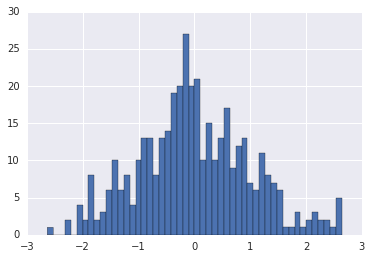

In [3]:
#Scale and standardize, once mets are scaled/standardized add back covariates
X = data_clean[data_clean.columns[0:659]]
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Xcolumns=X.columns
X = scaler.fit_transform(X)
X=pd.DataFrame(data=X,columns=Xcolumns,index=data_clean.index)
print (X.shape)
sns.set(font_scale=1.00)
print (X['root.metabolite.scaled.lipid.steroid.5alpha-androstan-3beta,17alpha-diol disulfate:scaled'].hist(bins=50))
X['BMI']=data_clean['BMI']
X['Age']=data_clean['Age']
X['shannon']=data_clean['shannon']
X['sex']=data_clean['sex']

40
no. of mets with >10% variance explained: 9


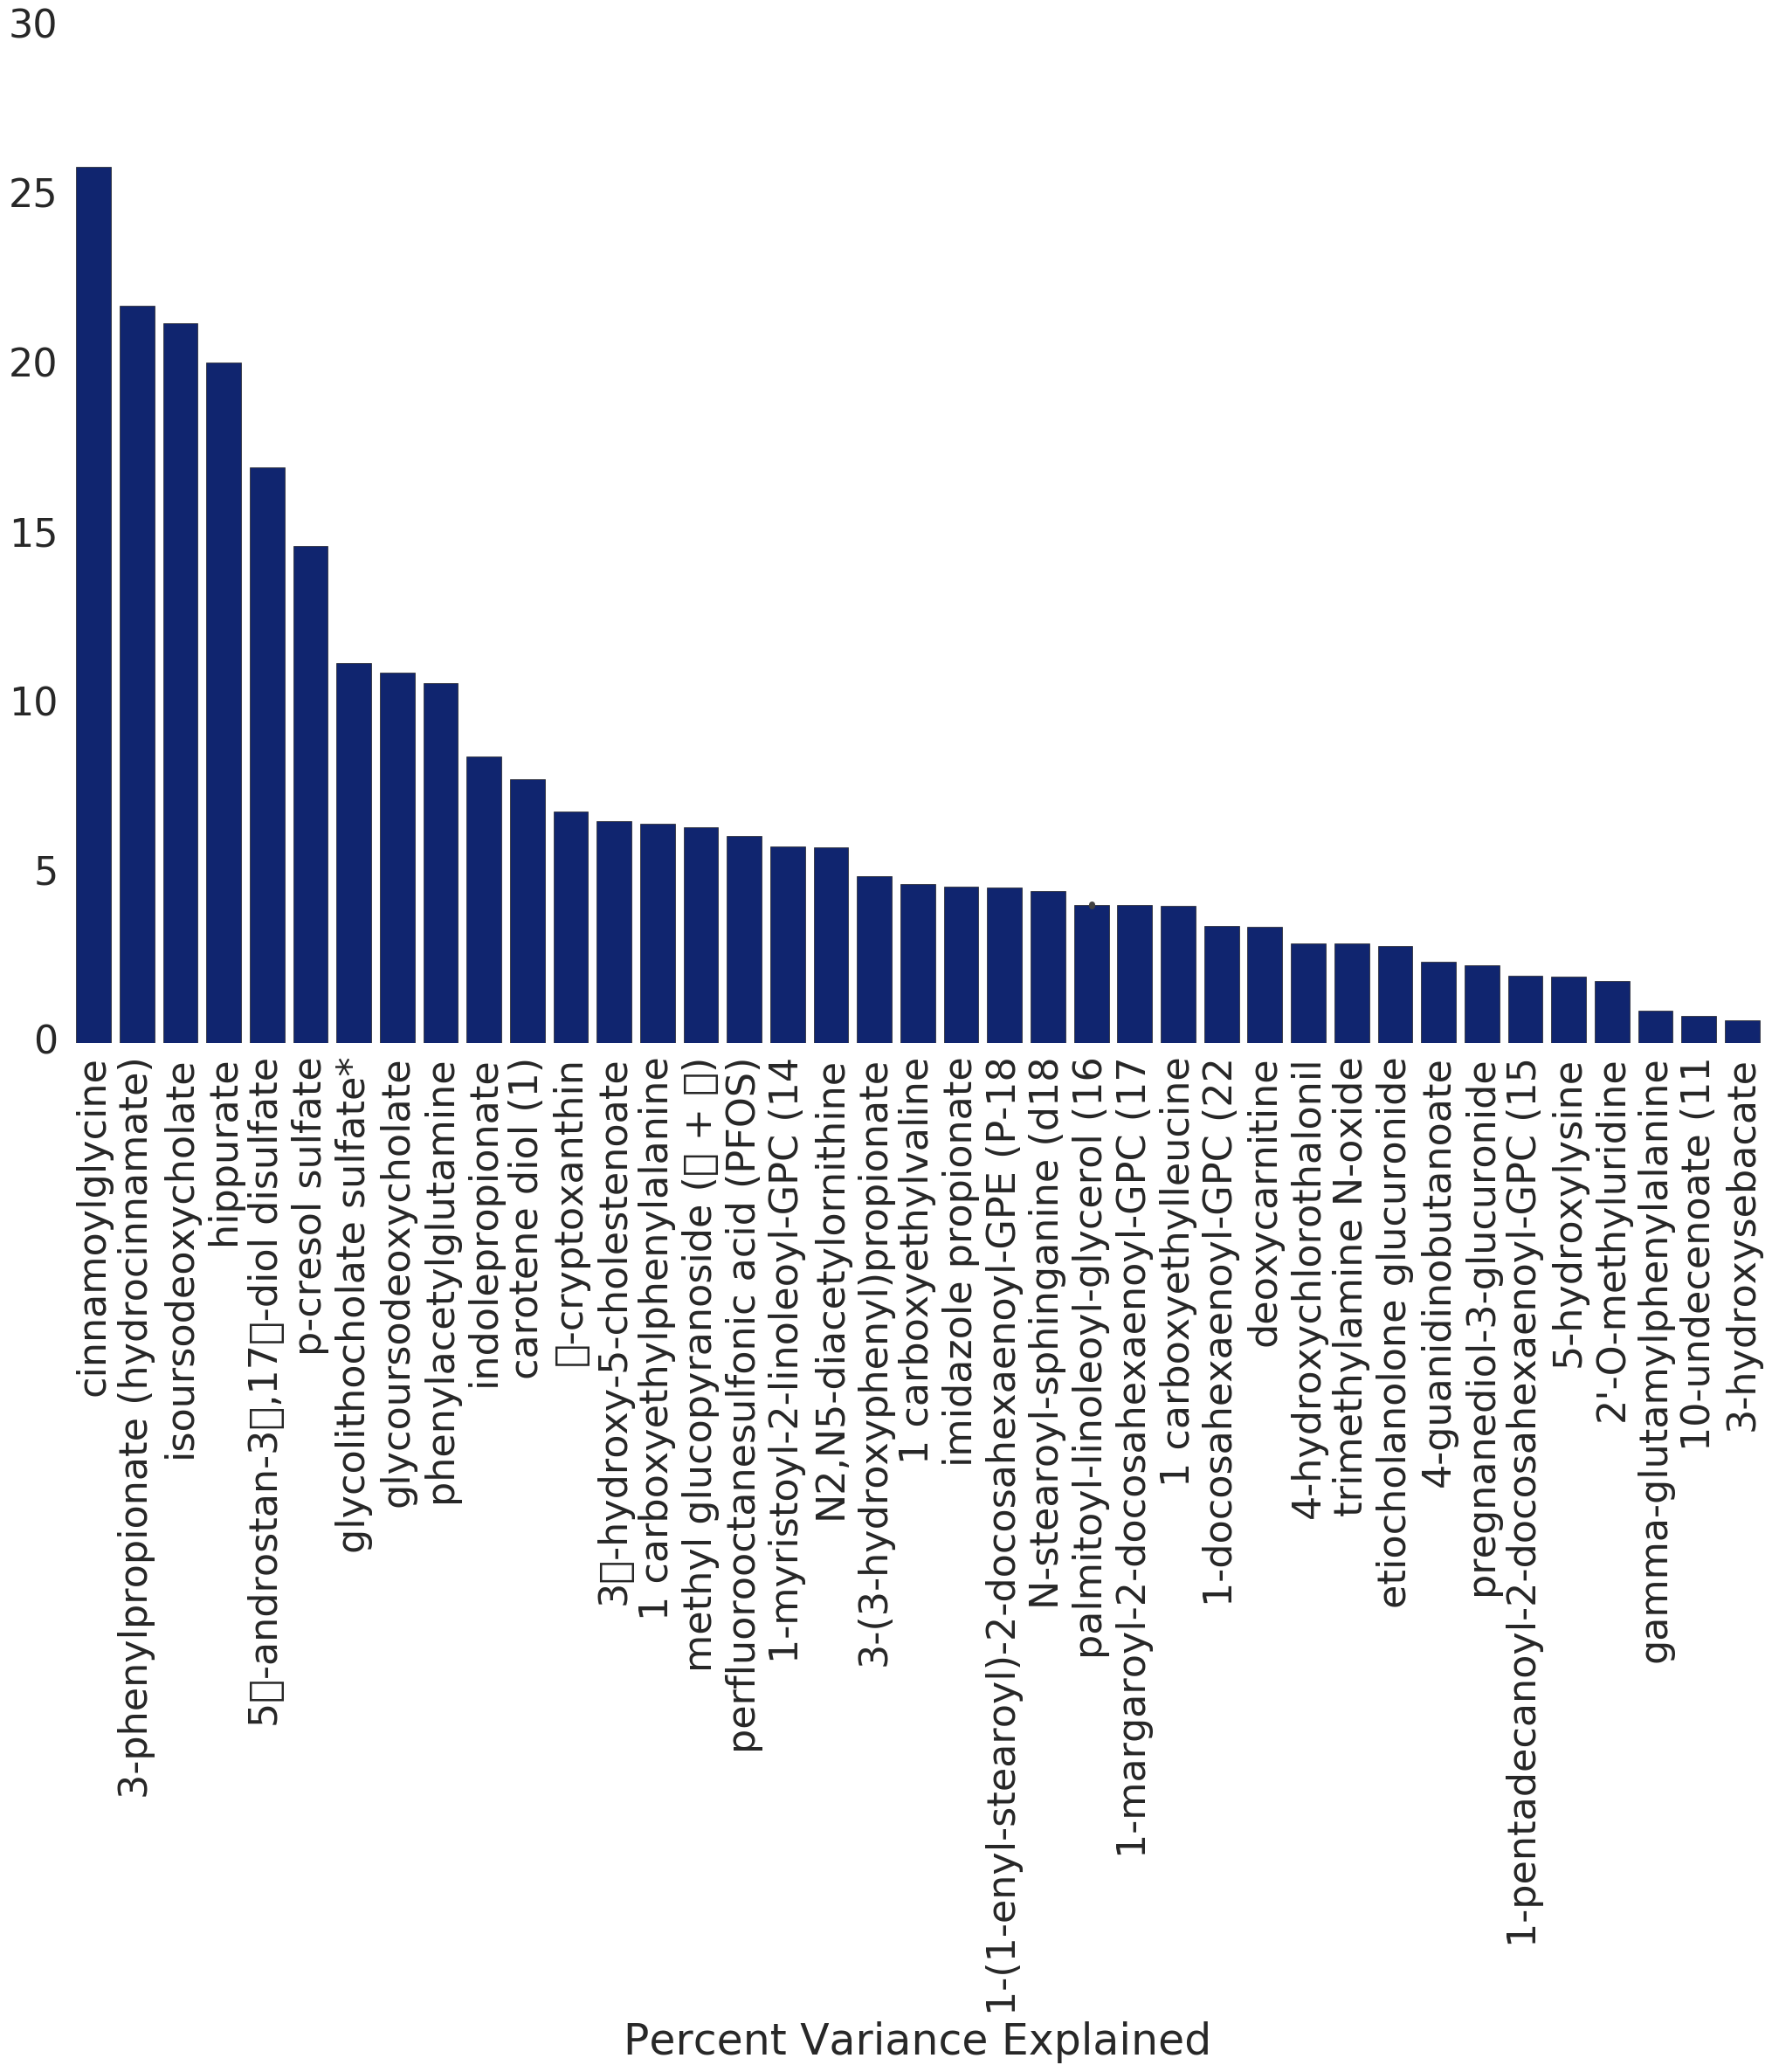

In [4]:
#Assess relationship of each metabolite with shannon independently
mets_cov_df=X
#generate list of all metabolites retained by LASSO (40)
mets=LASSO_coef.index.tolist()
#run analysis assessing the relationship of each metabolite and shannon
r_squared=[]
analyte=[]
p=[]
for x in mets:
    mets_cov_df['response']=mets_cov_df[x]
    results = smf.ols('shannon ~ response', data=mets_cov_df).fit()
    p_extract=results.pvalues.tolist()
    p_test=p_extract[1]
    p.append(p_test)
    r_squared.append(results.rsquared*100)
    analyte.append(x)
mets_independent=pd.DataFrame()
mets_independent['analyte']=analyte
mets_independent['p_value']=p
mets_independent['r_squared']=r_squared
mets_independent.set_index('analyte',inplace=True)
results_solo_mets = list([x.split(":")[0].split(".")[-1] for x in mets_independent.index.tolist()])
mets_independent.index=results_solo_mets
mets_independent.sort_values(by='r_squared',ascending=False,inplace=True)
mets_independent.index = [ x.replace('_', ' ') for x in mets_independent.index.tolist()]
mets_independent.index=mets_independent.index.to_series().replace({'alpha':'α',"beta":'β'},regex=True)
sns.set(font_scale=2,context='poster',font='Arial',style='white')
sns.set_color_codes("dark")
plt.figure(figsize=[25,15], dpi=100)
ax=sns.barplot(x=mets_independent.index, y='r_squared',data=mets_independent,label="Total", color="b")
for item in ax.get_xticklabels():
    item.set_rotation(90)
ax.set(ylabel="",
       xlabel="Percent Variance Explained")
sns.despine(left=True, bottom=True)
#confirm no. of metabolites is 40
print (len(mets_independent))
#check how man mets explain over 10% of variance in Shannon
mets_10rsq=len(mets_independent[mets_independent['r_squared']>10])
print ('no. of mets with >10% variance explained:', mets_10rsq )

In [5]:
#Assess relationship of each metabolite with Shannon adjusting for covariates
#import df with scaled mets with added covariate columns
mets_cov_df=X
#run regression with shannon as dependent variable and each of the 40 mets as the independent variable, adjusting for BMI, age, and sex
p=[]
analyte=[]
test_value=[]
results=pd.DataFrame()
for x in mets:
    mets_cov_df['response']=X[x]
    results = smf.ols('shannon ~ BMI+Age+sex+response', data=mets_cov_df).fit()
    p_extract=results.pvalues.tolist()
    p_test=p_extract[4]
    analyte.append(x)
    p.append(p_test)
    parameters=results.params.tolist()
    param=parameters[4]
    test_value.append(param)
results_ols=pd.DataFrame()
results_ols['analyte']=analyte
results_ols['pvalue']=p
results_ols.set_index('analyte')
#multiple hypothesis correction
results_ols['corr_pval']=multi.multipletests(results_ols['pvalue'], alpha=0.05, method='fdr_bh', is_sorted=False,returnsorted=False)[1]
results_ols['covariate_adjusted_Beta_coeff']=test_value
#confirm no. of metaoblites tested
print (len(results_ols))
results_ols=results_ols.set_index('analyte')
results_ols.head()
results_ols['LASSO_coefficient']=LASSO_coef['mean']
results_ols['No_of_zero_coefficients']=LASSO_coef['zeroes']
results_ols.sort_values(by='LASSO_coefficient',ascending=False,inplace=True)
#no. of metabolites significantly associated with shannon after adjusting for covariates and multiple hypothesis testing
significant=results_ols[results_ols['corr_pval']<0.05].index.tolist()
print ('no. of mets significantly associated with shannon after adjusting for covariates (FDR<0.05)',len(significant))

40
no. of mets significantly associated with shannon after adjusting for covariates (FDR<0.05) 35


In [6]:
#Supplementary Table 2
results_ols.head()

,pvalue,corr_pval,covariate_adjusted_Beta_coeff,LASSO_coefficient,No_of_zero_coefficients
analyte,,,,,
"root.metabolite.scaled.lipid.steroid.5alpha-androstan-3beta,17alpha-diol disulfate:scaled",3.736218e-16,2.988974e-15,0.182098,0.078496,0
root.metabolite.scaled.xenobiotics.benzoate_metabolism.hippurate:scaled,1.940974e-17,1.940974e-16,0.182694,0.057441,0
root.metabolite.scaled.xenobiotics.food_component_plant.cinnamoylglycine:scaled,5.610008e-23,2.244003e-21,0.215643,0.056612,0
root.metabolite.scaled.amino_acid.phenylalanine_and_tyrosine_metabolism.p-cresol sulfate:scaled,4.747588e-14,3.165059e-13,0.164191,0.051643,0
root.metabolite.scaled.xenobiotics.food_component_plant.methyl glucopyranoside (alpha + beta):scaled,2.130724e-05,6.087782e-05,0.093952,0.027840,0


In [7]:
#import df containg clinical labs WITH covariates added (sex, age, BMI)
chemistries=pd.DataFrame.from_csv("chemistries.csv")
chemistries.shape
#create list of all clinical labs omitting covariates and shannon

(399, 81)

In [8]:
#Scale and standardize chemistries
C = chemistries.drop(['BMI','sex','age','shannon'],1)
#generate a list of all clinical labs for testing
just_analytes=C.columns.tolist()
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Ccolumns=C.columns
C = scaler.fit_transform(C)
C=pd.DataFrame(data=C,columns=Ccolumns,index=chemistries.index)
print (C.shape)

(399, 77)


In [9]:
#Figure 4B
#assess relationship between each clinical lab and shannon independently
p=[]
analyte=[]
test_value=[]
r_squared=[]
results_solo=pd.DataFrame()
for x in just_analytes:
        chemistries['response']=C[x]
        results = smf.ols('shannon ~  response', data=chemistries).fit()
        p_extract=results.pvalues.tolist()
        r_squared.append(results.rsquared*100)
        p_test=p_extract[1]
        analyte.append(x)
        p.append(p_test)
        parameters=results.params.tolist()
        param=parameters[1]
        test_value.append(param)
#results = smf.ols('shannon ~  BMI', data=reg_df).fit()
#p_extract=results.pvalues.tolist()
#r_squared.append(results.rsquared*100)
#p_test=p_extract[1]
#analyte.append('BMI')
#p.append(p_test)
#parameters=results.params.tolist()
#param=parameters[1]
#test_value.append(param)
results_solo['analyte']=analyte
results_solo['r_squared']=r_squared
results_solo['Beta_coeff']=test_value
results_solo['pvalue']=p
results_solo['corr_pval']=multi.multipletests(results_solo['pvalue'], alpha=0.05, method='fdr_bh', is_sorted=False,returnsorted=False)[1]
#results_solo['-log']=-(np.log10(results_solo['pvalue']))
results_solo.sort_values(by='r_squared',ascending=False,inplace=True)
print (len(results_solo))
results_solo=results_solo.set_index('analyte')
print('no. of signigicant correlations between clinical labs and shannon (FDR<0.05)=',len(results_solo[results_solo['corr_pval']<0.05]))

77
no. of signigicant correlations between clinical labs and shannon (FDR<0.05)= 28


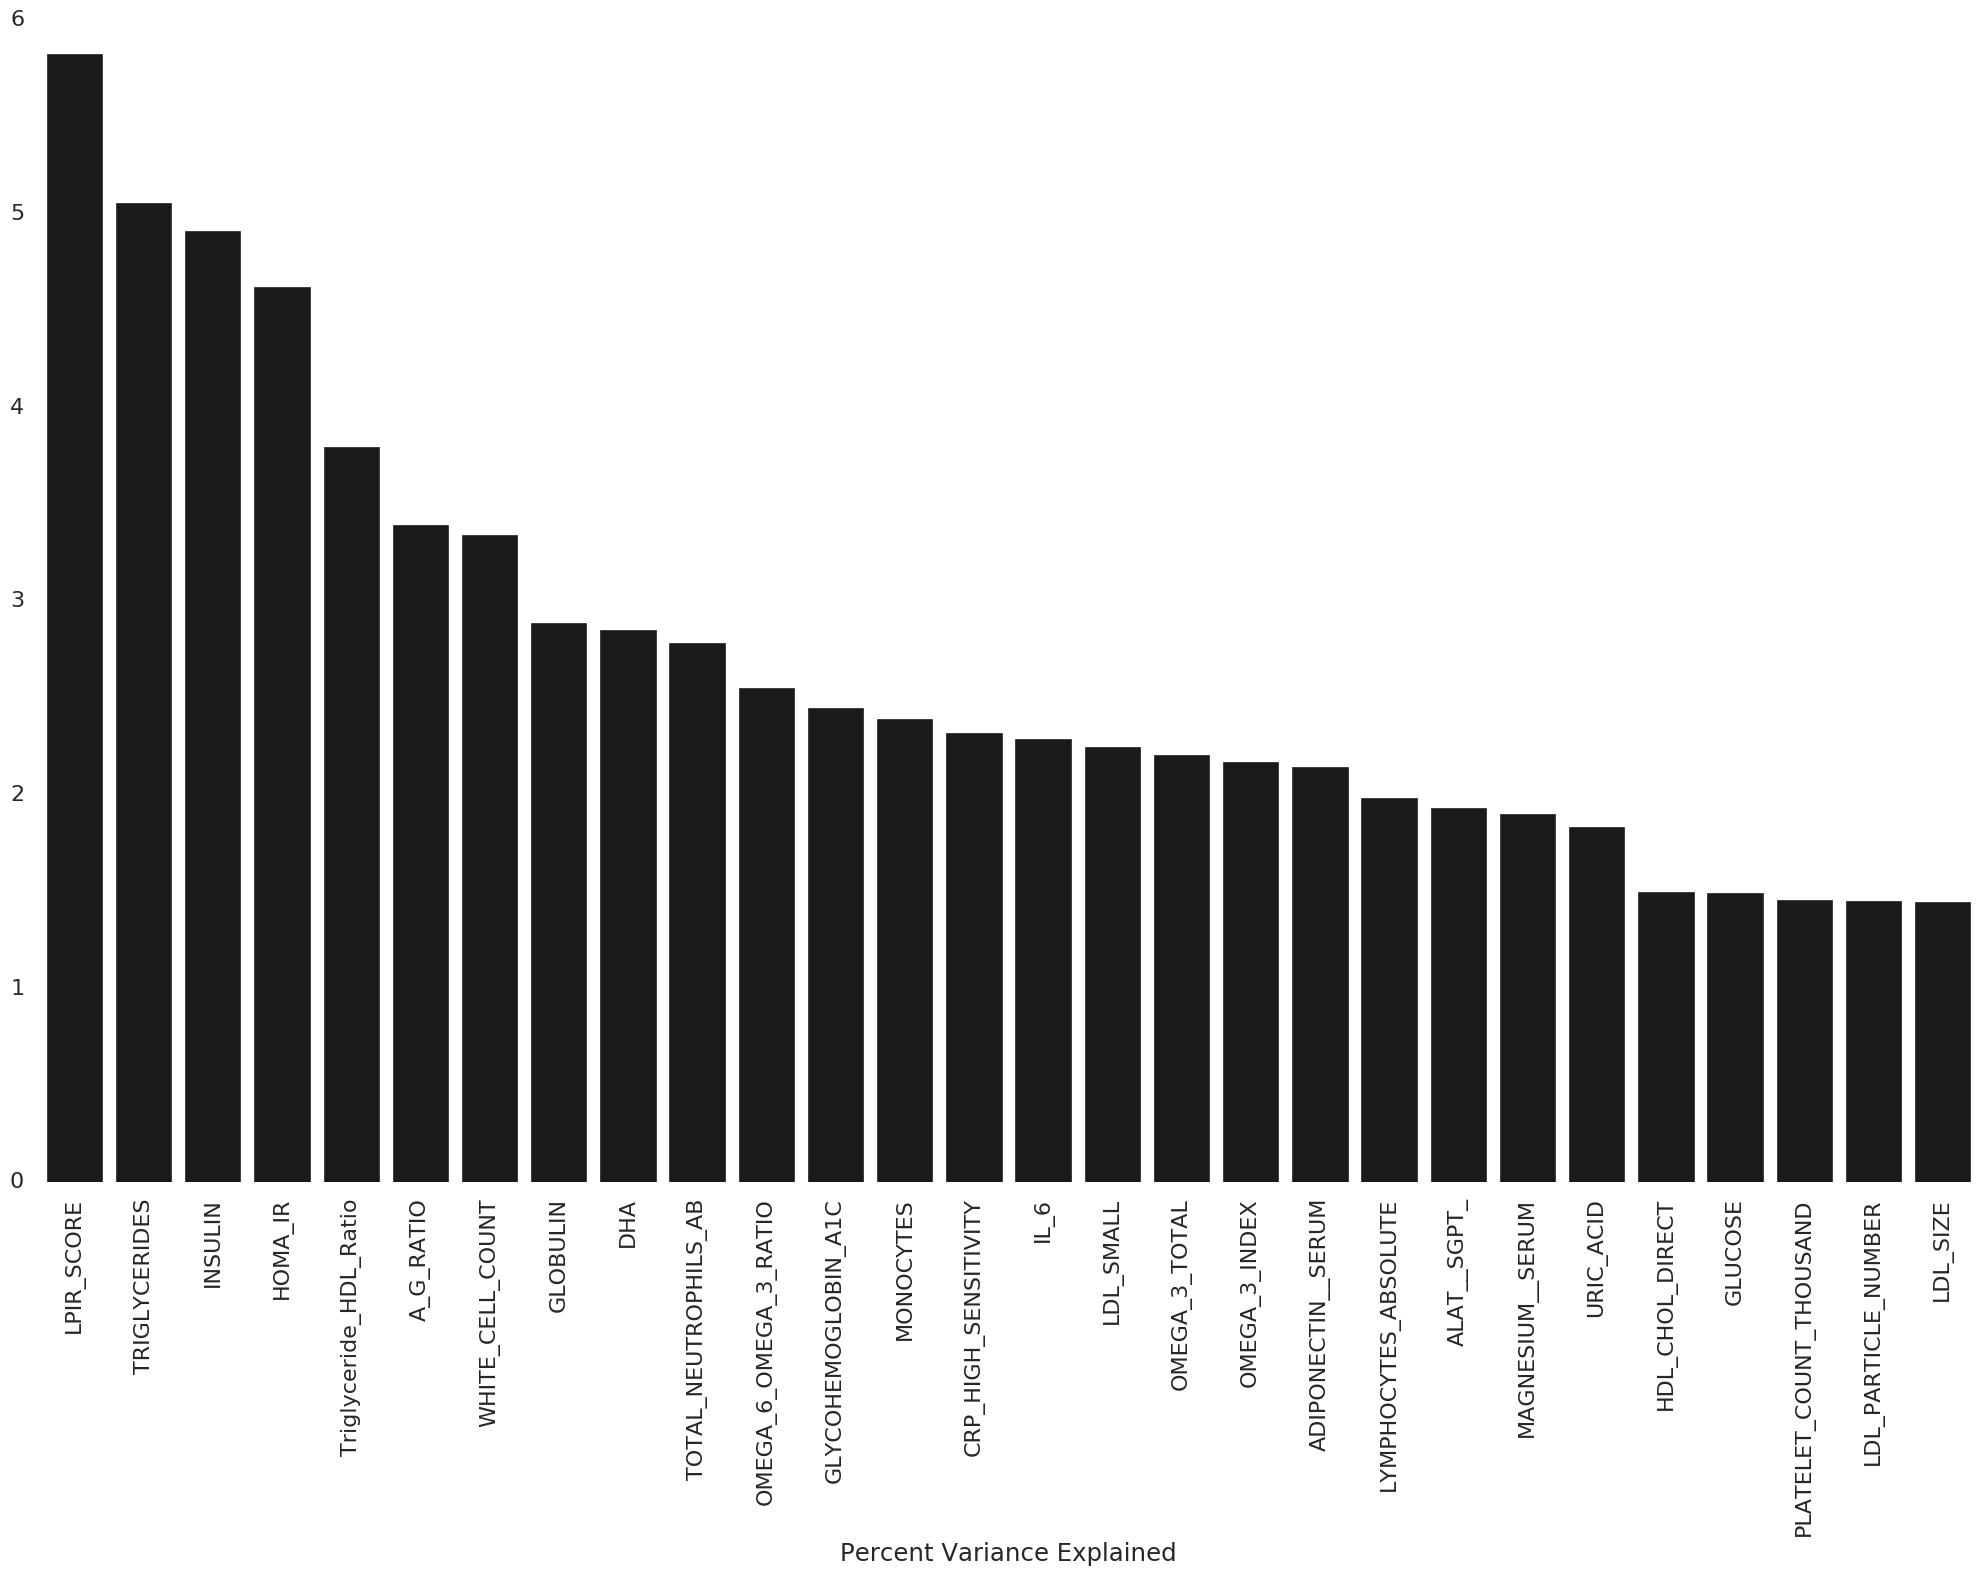

In [10]:
#plot variance explained by each clinical lab Figure 4B
significant=results_solo[results_solo['corr_pval']<0.05]
sns.set(font_scale=1,context='poster',font='Arial',style='white')
sns.set_color_codes("dark")
plt.figure(figsize=[25,15], dpi=100)
ax=sns.barplot(x=significant.index, y='r_squared',data=significant,label="Total", color="k")
for item in ax.get_xticklabels():
    item.set_rotation(90)
ax.set(ylabel="",
       xlabel="Percent Variance Explained")
sns.despine(left=True, bottom=True)

In [11]:
BMI_regression = smf.ols('shannon ~ BMI', data=chemistries).fit()
print ('Variance in Shannon diversity explained by BMI',BMI_regression.rsquared*100)

Variance in Shannon diversity explained by BMI 7.480529955093907


In [12]:
#Assess relationship with each clinical lab and shannon after adjusting for covariates
#Supplementary Table 2
p=[]
analyte=[]
test_value=[]
results_ols2=pd.DataFrame()
race=[]
for x in just_analytes:
        chemistries['response']=C[x]
        results = smf.ols('shannon ~  BMI+age+sex+response', data=chemistries).fit()
        p_extract=results.pvalues.tolist()
        p_test=p_extract[4]
        analyte.append(x)
        p.append(p_test)
        parameters=results.params.tolist()
        param=parameters[4]
        test_value.append(param)
results_ols2['analyte']=analyte
results_ols2['pvalue']=p
results_ols2['Adj_Beta_coeff']=test_value
results_ols2['corr_pval']=multi.multipletests(results_ols2['pvalue'], alpha=0.05, method='fdr_bh', is_sorted=False,returnsorted=False)[1]
results_ols2.sort_values(by='pvalue',inplace=True)
results_ols2.sort_values(by='corr_pval',ascending=True,inplace=True)
print (len(results_ols2))
results_ols2=results_ols2.set_index('analyte')
print('no. of signigicant correlations between clinical labs and shannon adjusted for sex, age and BMI(FDR<0.05)=',len(results_ols2[results_ols2['corr_pval']<0.05]))

77
no. of signigicant correlations between clinical labs and shannon adjusted for sex, age and BMI(FDR<0.05)= 2


In [13]:
results_ols2[results_ols2['corr_pval']<0.05]

,pvalue,Adj_Beta_coeff,corr_pval
analyte,,,
LPIR_SCORE,0.000523,-0.085355,0.040249
TRIGLYCERIDES,0.001075,-0.077858,0.041379


# Generating Figure 5

In [14]:
#Stratify participants based on BMI into obese categories
a=[]
for x in chemistries['BMI']:
    if x<25:
        a.append('Normal Weight')
    elif x>=25 and x<30:
        a.append('Overweight')
    elif x>=30 and x<35:
        a.append('Obese I')
    elif x>=35:
        a.append('Obese II/III')
chemistries['Obesity']=a
X['_5alpha']=X['root.metabolite.scaled.lipid.steroid.5alpha-androstan-3beta,17alpha-diol disulfate:scaled']
X['Obesity']=chemistries['Obesity']

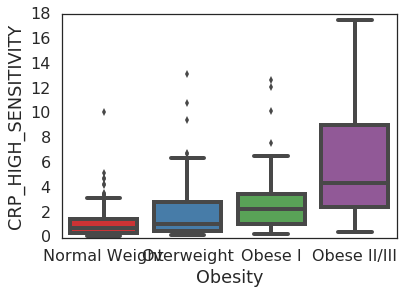

In [15]:
plt.ylim(0,18)
ax=sns.boxplot(y=chemistries['CRP_HIGH_SENSITIVITY'],x=chemistries['Obesity'],order=['Normal Weight','Overweight','Obese I','Obese II/III'],palette='Set1',showfliers=True,linewidth=4, meanline=True,showmeans=False)

In [16]:
X['Obesity']=chemistries['Obesity']
OB=X[X['Obesity']=='Obese II/III']
N=X[X['Obesity']!='Obese II/III']
#Pearsonr for correlation of shannon and 5alpha-androstan-3b in OBII/III participants FIGURE 5D
print("OBII/III 5alpha v. shannon",scipy.stats.pearsonr(OB['shannon'],OB['_5alpha']))
#Pearsonr for correlation of shannon and 5alpha-androstan-3b in non-OBII/III participants FIGURE 5D
print('NONE OBII/III (BMI<35) 5alpha v. shannon',scipy.stats.pearsonr(N['shannon'],N['_5alpha']))

OBII/III 5alpha v. shannon (-0.02395715341093035, 0.8608749582233104)
NONE OBII/III (BMI<35) 5alpha v. shannon (0.45903359268912924, 2.8018652695537704e-19)


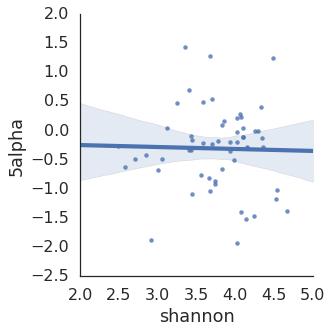

In [17]:
#Generate scatter plot for Figure 5D
sns.set(font_scale=1,context='poster',font='Arial',style='white')
plt.figure(figsize=[20,20], dpi=200)
ax=sns.lmplot('shannon','_5alpha', OB,palette='Set1',fit_reg=True)
ax.set_axis_labels('shannon', '5alpha')
plt.show()

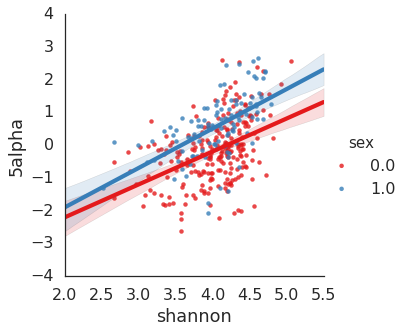

In [18]:
#Generate scatter plot for Figure 5D
sns.set(font_scale=1,context='poster',font='Arial',style='white')
plt.figure(figsize=[20,20], dpi=200)
ax=sns.lmplot('shannon','_5alpha', N,hue='sex',palette='Set1',fit_reg=True)
ax.set_axis_labels('shannon', '5alpha')
plt.show()

In [19]:
import statsmodels.formula.api as smf
results = smf.ols('shannon ~ sex+Age+_5alpha', data=OB).fit()
print ('B-coefficient for _5alpha in OBII',results.params[3])
print ('p-value for _5alpha in OBII corrected for sex and age',results.pvalues[3])

B-coefficient for _5alpha in OBII -0.01301463767297395
p-value for _5alpha in OBII corrected for sex and age 0.89343590577708
